# Myocardial image quality estimation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/metrics/myocardial_quality_example.ipynb) &nbsp; [![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/metrics/myocardial_quality_example.ipynb) &nbsp; [![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/gillesvdv/mobilenetv2_regional_quality) &nbsp; [![UMB](https://img.shields.io/badge/UMB-Paper-431E4F.svg)](https://www.sciencedirect.com/science/article/pii/S0301562924004691)

This notebook demonstrates regional image quality scoring for apical echocardiography views using a MobileNetV2-based model.

**References**:
- Paper: [Regional Image Quality Scoring for 2-D Echocardiography Using Deep Learning](https://www.sciencedirect.com/science/article/pii/S0301562924004691), Gilles Van De Vyver et al.
- GitHub: [arqee](https://github.com/GillesVanDeVyver/arqee) (original implementation of the model and visualization)

‼️ **Important:** This notebook is optimized for **GPU/TPU**. Code execution on a **CPU** may be very slow.

If you are running in Colab, please enable a hardware accelerator via:

**Runtime → Change runtime type → Hardware accelerator → GPU/TPU** 🚀. 

In [1]:
%%capture
%pip install zea
%pip install onnxruntime # needed for both segmentation and image quality models

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
from keras import ops
from zea.visualize import plot_shape_from_mask
import numpy as np

from zea import init_device
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.visualize import set_mpl_style
from zea.io_lib import matplotlib_figure_to_numpy, save_video

init_device(verbose=False)
set_mpl_style()

zea: Using backend 'tensorflow'


## Loading models
To predict regional image quality, we need both:
- a segmentation model (for LV and myocardium regions)
- the image quality model

For more details on segmentation, see the [LV segmentation notebook](../models/left_ventricle_segmentation_example.ipynb).

In [3]:
from zea.models.regional_quality import MobileNetv2RegionalQuality

quality_model = MobileNetv2RegionalQuality.from_preset("mobilenetv2_regional_quality")

In [4]:
from zea.models.lv_segmentation import AugmentedCamusSeg

seg_model = AugmentedCamusSeg.from_preset("augmented_camus_seg")

## Load CAMUS Validation Data

We load a batch of images from the CAMUS validation set.

In [5]:
# Load a batch and run both models.
n_imgs = 1
INFERENCE_SIZE = 256
val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image_sc",
    batch_size=n_imgs,
    shuffle=True,
    image_range=[-45, 0],
    clip_image_range=True,
    normalization_range=[-1, 1],
    image_size=(INFERENCE_SIZE, INFERENCE_SIZE),
    resize_type="resize",
    seed=42,
    n_frames=10,
)
batch = next(iter(val_dataset))
# bring frame dimension to front
# [frames, height, width, channels]
batch = ops.swapaxes(batch, 0, -1)

zea: Using pregenerated dataset info file: /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on October 01, 2025
zea: Remove /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.


zea: H5Generator: Shuffled data.


Now we will run the segmentation model to get the LV and myocardium masks, and then feed those to the image quality model to get regional quality scores.

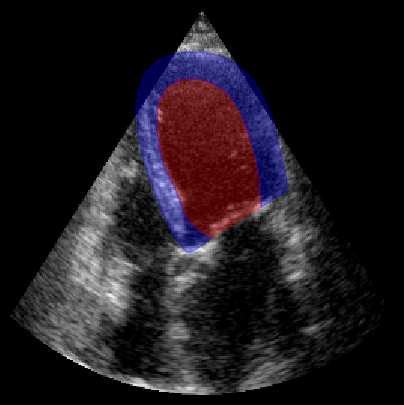

Predicted regional image quality scores:
  basal_left: 4.59
  mid_left: 5.21
  apical_left: 3.60
  apical_right: 2.37
  mid_right: 2.64
  basal_right: 2.99
  annulus_left: 6.01
  annulus_right: 4.85


In [6]:
# onnx model needs [batch, channels, height, width]
batch_np = ops.convert_to_numpy(batch)
onnx_input = np.transpose(batch_np, (0, 3, 1, 2))

# Run the image quality model
scores = quality_model.call(onnx_input)
scores = np.array(scores)

# Run the segmentation model (LV + myocardium)
outputs_seg = seg_model.call(onnx_input)
outputs_seg = np.array(outputs_seg)
masks = np.argmax(outputs_seg, axis=1).astype(np.uint8)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(batch_np[0], cmap="gray")
plot_shape_from_mask(ax, masks[0] == 1, color="red", alpha=0.3)  # LV
plot_shape_from_mask(ax, masks[0] == 2, color="blue", alpha=0.3)  # Myocardium
plt.axis("off")
plt.show()

region_labels = [
    "basal_left",
    "mid_left",
    "apical_left",
    "apical_right",
    "mid_right",
    "basal_right",
    "annulus_left",
    "annulus_right",
]

print("Predicted regional image quality scores:")
for label, score in zip(region_labels, scores[0]):
    print(f"  {label}: {score:.2f}")

We need the `arqee` package for a complete visualization.
The colored overlay shows the predicted regional image quality for each myocardial region.

In [7]:
%%capture
%pip install git+https://github.com/GillesVanDeVyver/arqee

In [8]:
import arqee

frames = []
for image, mask, labels in zip(batch_np, masks, scores):
    labels = [int(i) for i in labels]
    image = np.squeeze(image, axis=-1)
    fig, *_ = arqee.plot_quality_prediction_result(image, mask, labels)
    frames.append(matplotlib_figure_to_numpy(fig))
    plt.close(fig)

save_video(frames, "./myocardial_image_quality.gif", fps=10)

zea: Succesfully saved GIF to -> ./myocardial_image_quality.gif


![myocardial image quality](./myocardial_image_quality.gif)